In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import nltk
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [21]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
data_train = pd.read_csv("/content/sample_data/train.csv")
data_test = pd.read_csv("/content/sample_data/test.csv")

##EDA

In [36]:
print(data_train.head())
print(data_train.info())
print(data_train.describe())

                                              review sentiment  \
0  I caught this little gem totally by accident b...  positive   
1  I can't believe that I let myself into this mo...  negative   
2  *spoiler alert!* it just gets to me the nerve ...  negative   
3  If there's one thing I've learnt from watching...  negative   
4  I remember when this was in theaters, reviews ...  negative   

                          preprocessed_text_stemming  \
0  caught littl gem total accid back reviv theatr...   
1  ca believ let movi accomplish favor friend ask...   
2  spoiler alert get nerv peopl remak use term lo...   
3  one thing learnt watch georg romero creepshow ...   
4  rememb theater review said horribl well think ...   

                     preprocessed_text_lemmatization  
0  caught little gem totally accident back reviva...  
1  ca believe let movie accomplish favor friend a...  
2  spoiler alert get nerve people remake use term...  
3  one thing learnt watching george romero cre

###Class Distribution

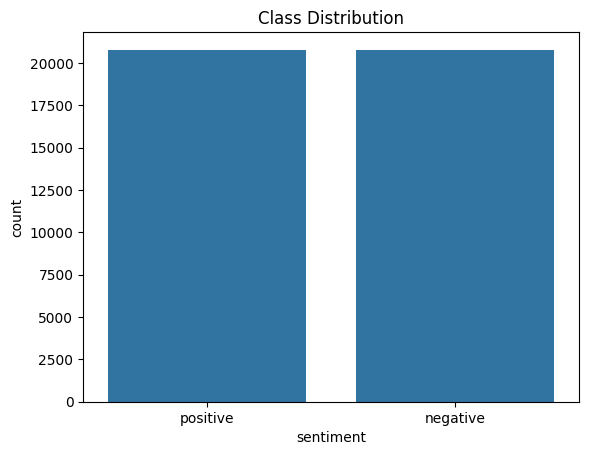

In [42]:
sns.countplot(x='sentiment', data=data_train)
plt.title('Class Distribution')
plt.show()

###Text Length Analysis

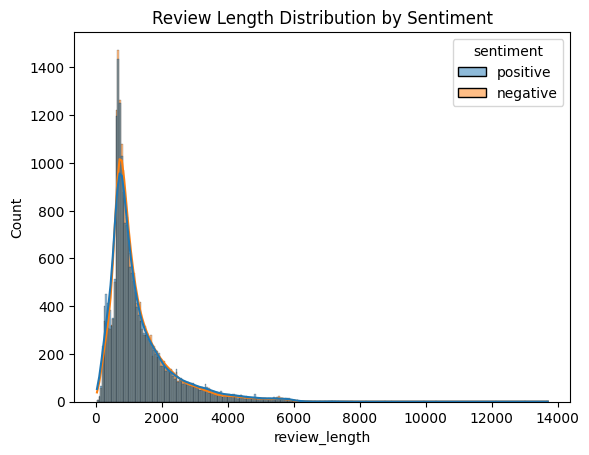

In [43]:
data_train['review_length'] = data_train['review'].apply(len)
sns.histplot(data=data_train, x='review_length', hue='sentiment', kde=True)
plt.title('Review Length Distribution by Sentiment')
plt.show()

###Word Cloud

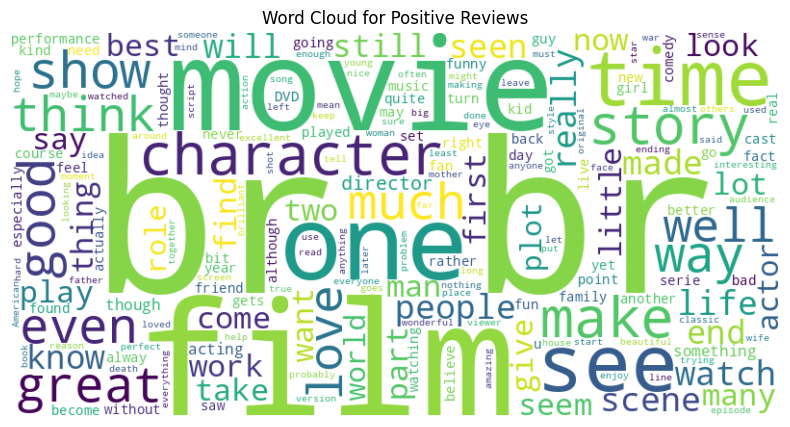

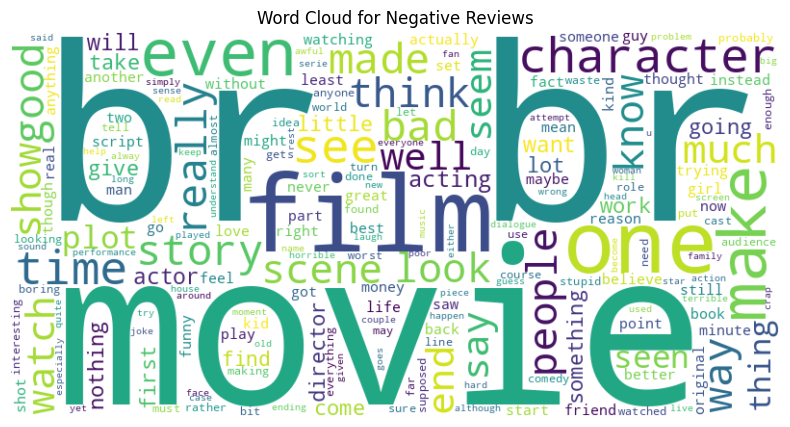

In [45]:
# Word Cloud
positive_reviews = data_train[data_train['sentiment'] == 'positive']['review']
negative_reviews = data_train[data_train['sentiment'] == 'negative']['review']

# Word Cloud for Positive Reviews
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

# Word Cloud for Negative Reviews
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_reviews))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

From the EDA, it might be hypothesize that the word "film" was more used in positive sentiments, while the word "movie" in the opposite way.

##Text preprocessing

In [23]:
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

##Tokenization, Stop-words filtering, Punctuation removal, and Lowercasing

In [24]:
def preprocess_text(text, use_stemming=True):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Removing punctuation and convert to lowercase
    tokens = [word for word in tokens if word.lower() not in stop_words]

    if use_stemming:
        tokens = [porter.stem(word) for word in tokens]  # Applying stemming
    else:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Applying lemmatization

    return ' '.join(tokens)

##Apply preprocessing to the training data

In [26]:
data_train['preprocessed_text_stemming'] = data_train['review'].apply(lambda x: preprocess_text(x, use_stemming=True))
data_train['preprocessed_text_lemmatization'] = data_train['review'].apply(lambda x: preprocess_text(x, use_stemming=False))


###Splitting the data

In [31]:
X_train_stem, X_test_stem, y_train, y_test = train_test_split(data_train['preprocessed_text_stemming'], data_train['sentiment'], test_size=0.2, random_state=42)
X_train_lemma, X_test_lemma, y_train, y_test = train_test_split(data_train['preprocessed_text_lemmatization'], data_train['sentiment'], test_size=0.2, random_state=42)


##Models and Training

###Models

In [32]:
models = {
    'Logistic Regression (CountVectorizer, Stemming)': LogisticRegression(max_iter=10000),
    'Logistic Regression (TfidfVectorizer, Stemming)': LogisticRegression(max_iter=10000),
    'Logistic Regression (CountVectorizer, Lemmatization)': LogisticRegression(max_iter=10000),
    'Logistic Regression (TfidfVectorizer, Lemmatization)': LogisticRegression(max_iter=10000),
    'Multinomial Naive Bayes (CountVectorizer, Stemming)': MultinomialNB(),
    'Multinomial Naive Bayes (TfidfVectorizer, Stemming)': MultinomialNB(),
    'Multinomial Naive Bayes (CountVectorizer, Lemmatization)': MultinomialNB(),
    'Multinomial Naive Bayes (TfidfVectorizer, Lemmatization)': MultinomialNB(),
    'Random Forest (CountVectorizer, Stemming)': RandomForestClassifier(n_estimators=20),
    'Random Forest (TfidfVectorizer, Stemming)': RandomForestClassifier(n_estimators=20),
    'Random Forest (CountVectorizer, Lemmatization)': RandomForestClassifier(n_estimators=20),
    'Random Forest (TfidfVectorizer, Lemmatization)': RandomForestClassifier(n_estimators=20)
}

###Training

In [33]:
best_model = None
best_accuracy = 0

for model_name, model in models.items():
    if 'CountVectorizer' in model_name:
        vectorizer = CountVectorizer()
    elif 'TfidfVectorizer' in model_name:
        vectorizer = TfidfVectorizer()
    else:
        vectorizer = None

    if 'Stemming' in model_name:
        X_train = X_train_stem
        X_test = X_test_stem
    elif 'Lemmatization' in model_name:
        X_train = X_train_lemma
        X_test = X_test_lemma

    # Use a pipeline for easier integration with grid search
    pipeline = make_pipeline(vectorizer, model) if vectorizer else make_pipeline(model)

    # Hyperparameter tuning using GridSearchCV
    param_grid = {}
    if 'Logistic Regression' in model_name:
        param_grid = {'logisticregression__C': [0.1, 1, 10]}

    if 'Random Forest' in model_name:
        param_grid = {'randomforestclassifier__n_estimators': [10, 20, 30]}

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f'{model_name} Accuracy: {accuracy}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = grid_search.best_estimator_

Logistic Regression (CountVectorizer, Stemming) Accuracy: 0.8835838845460012
Logistic Regression (TfidfVectorizer, Stemming) Accuracy: 0.8916416115453999
Logistic Regression (CountVectorizer, Lemmatization) Accuracy: 0.885628382441371
Logistic Regression (TfidfVectorizer, Lemmatization) Accuracy: 0.8909200240529164
Multinomial Naive Bayes (CountVectorizer, Stemming) Accuracy: 0.8547203848466627
Multinomial Naive Bayes (TfidfVectorizer, Stemming) Accuracy: 0.8579675285628382
Multinomial Naive Bayes (CountVectorizer, Lemmatization) Accuracy: 0.8591701743836441
Multinomial Naive Bayes (TfidfVectorizer, Lemmatization) Accuracy: 0.86458208057727
Random Forest (CountVectorizer, Stemming) Accuracy: 0.8382441371016236
Random Forest (TfidfVectorizer, Stemming) Accuracy: 0.8318701142513529
Random Forest (CountVectorizer, Lemmatization) Accuracy: 0.8363199037883343
Random Forest (TfidfVectorizer, Lemmatization) Accuracy: 0.830426939266386


##Evaluating on test data

In [35]:
data_test['preprocessed_text_stemming'] = data_test['review'].apply(lambda x: preprocess_text(x, use_stemming=True))
data_test['preprocessed_text_lemmatization'] = data_test['review'].apply(lambda x: preprocess_text(x, use_stemming=False))


##Stemming testing

In [38]:
# Inference on the test set (Stemming)
test_predictions_stem = best_model.predict(data_test['preprocessed_text_stemming'])

# Compare accuracy with actual sentiments in test_data
test_accuracy_stem = accuracy_score(data_test['sentiment'], test_predictions_stem)
print(f'Test Accuracy with Actual Sentiments (Stemming): {test_accuracy_stem}')

# Additional: Print classification report for more detailed evaluation
print("Classification Report (Stemming):")
print(classification_report(data_test['sentiment'], test_predictions_stem))

Test Accuracy with Actual Sentiments (Stemming): 0.8899
Classification Report (Stemming):
              precision    recall  f1-score   support

    negative       0.89      0.88      0.89      5000
    positive       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



###Lemmatization testing

In [39]:
test_predictions_lemma = best_model.predict(data_test['preprocessed_text_lemmatization'])

# Compare accuracy with actual sentiments in test_data
test_accuracy_lemma = accuracy_score(data_test['sentiment'], test_predictions_lemma)
print(f'Test Accuracy with Actual Sentiments (Lemmatization): {test_accuracy_lemma}')

# Additional: Print classification report for more detailed evaluation
print("Classification Report (Lemmatization):")
print(classification_report(data_test['sentiment'], test_predictions_lemma))


Test Accuracy with Actual Sentiments (Lemmatization): 0.8271
Classification Report (Lemmatization):
              precision    recall  f1-score   support

    negative       0.84      0.81      0.82      5000
    positive       0.81      0.85      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



##Conclusion

###Model choice

Choosing shallow learning models such as: Logistic Regression, Multinomial Naive Bayes, Random Forest were to the fact that training DL took too much resources and time. (And the running out of T4 GPU on Google collab)

Among those 3 models, after hyperparameter tuning the best was Logistic Regression having 89% accuracy.

###TF-IDF Vectorizer VS Count Vectorizer

TF-IDF Vectorizer performed better compared to the Count Vectorizer during the training process evaluation

###Lemmatization VS Stemming


From the given results lemmatizing the text gave better accuracy compared to stemming

###Business Usage

By analyzing audience feedback from reviews studios and streaming platforms gain insights into viewer sentiments. Positive sentiments guide marketing and content strategies, while addressing negative sentiments help in refining future productions